In [1]:
# %% ------------------------------------------------------------------
# SECTION 1 – LOAD & INSPECT THE DATA  (answers Q1)
# ---------------------------------------------------------------------
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

DATA_URL = "https://data.ny.gov/resource/vxuj-8kew.csv?$limit=200000"
print("Downloading dataset …")
raw = pd.read_csv(DATA_URL)
print(f"Rows: {len(raw):,}   Columns: {len(raw.columns)}")

_non_alnum = re.compile(r"[^a-z0-9]+")
def clean_col(col: str) -> str:
    col = col.lower()
    col = _non_alnum.sub("_", col)
    return re.sub(r"_+", "_", col).strip("_")

raw.columns = [clean_col(c) for c in raw.columns]
df = raw.copy()
df["date"] = pd.to_datetime(df["date"])

print("\nCleaned column names:")
print(df.columns.tolist())


Rows: 1,776   Columns: 15

Cleaned column names:
['date', 'subways_total_estimated_ridership', 'subways_of_comparable_pre_pandemic_day', 'buses_total_estimated_ridersip', 'buses_of_comparable_pre_pandemic_day', 'lirr_total_estimated_ridership', 'lirr_of_comparable_pre_pandemic_day', 'metro_north_total_estimated_ridership', 'metro_north_of_comparable_pre_pandemic_day', 'access_a_ride_total_scheduled_trips', 'access_a_ride_of_comparable_pre_pandemic_day', 'bridges_and_tunnels_total_traffic', 'bridges_and_tunnels_of_comparable_pre_pandemic_day', 'staten_island_railway_total_estimated_ridership', 'staten_island_railway_of_comparable_pre_pandemic_day']


In [2]:
# %% ------------------------------------------------------------------
# SECTION 2 – SELECT TARGET & BUILD FEATURES  (answers Q2)
# ---------------------------------------------------------------------
MODE = "subways"          

def find_pct_col(mode: str) -> str:
    pattern = rf"^{mode}.*of_comparable_pre_pandemic_day$"
    matches = [c for c in df.columns if re.match(pattern, c)]
    if not matches:
        raise KeyError(f"No column matches {pattern}")
    return matches[0]

TARGET = find_pct_col(MODE)
print(f"\nTarget column: {TARGET}")

feat = df[["date", TARGET]].copy()
feat["dow"]        = feat["date"].dt.dayofweek
feat["month"]      = feat["date"].dt.month
feat["is_weekend"] = feat["dow"].isin([5, 6]).astype(int)

for lag in (1, 7, 30):
    feat[f"lag{lag}"] = feat[TARGET].shift(lag)

feat.dropna(inplace=True)
print("\nFeature preview:")
print(feat.head())


Target column: subways_of_comparable_pre_pandemic_day

Feature preview:
         date  subways_of_comparable_pre_pandemic_day  dow  month  is_weekend  \
30 2020-03-31                                    0.09    1      3           0   
31 2020-04-01                                    0.09    2      4           0   
32 2020-04-02                                    0.09    3      4           0   
33 2020-04-03                                    0.09    4      4           0   
34 2020-04-04                                    0.09    5      4           1   

    lag1  lag7  lag30  
30  0.10  0.13   0.97  
31  0.09  0.12   0.96  
32  0.09  0.12   0.98  
33  0.09  0.12   0.99  
34  0.09  0.11   0.99  


In [3]:
# %% ------------------------------------------------------------------
# SECTION 3 – WEEKEND vs WEEKDAY T-TEST  (answers Q3)
# ---------------------------------------------------------------------
weekend = feat[feat["is_weekend"] == 1][TARGET]
weekday = feat[feat["is_weekend"] == 0][TARGET]
t_stat, p_val = stats.ttest_ind(weekend, weekday, equal_var=False)
print(f"\nT-test – weekend vs weekday:\n  t = {t_stat:.2f},  p = {p_val:.4f}")


T-test – weekend vs weekday:
  t = 7.64,  p = 0.0000


In [4]:
# %% ------------------------------------------------------------------
# SECTION 4 – RANDOM-FOREST FORECAST MODEL  (answers Q4)
# ---------------------------------------------------------------------
X = feat.drop(columns=["date", TARGET])
y = feat[TARGET]

tscv = TimeSeriesSplit(n_splits=5)
grid   = {"n_estimators": [200], "max_depth": [10, None]}
rf     = RandomForestRegressor(random_state=42, n_jobs=-1)
search = GridSearchCV(rf, grid, cv=tscv, scoring="neg_mean_absolute_error")
search.fit(X, y)

print("\nBest hyper-parameters:", search.best_params_)

split   = int(len(X) * 0.8)
X_tr, X_te = X.iloc[:split], X.iloc[split:]
y_tr, y_te = y.iloc[:split], y.iloc[split:]

best = search.best_estimator_.fit(X_tr, y_tr)
mae_tr = mean_absolute_error(y_tr, best.predict(X_tr))
mae_te = mean_absolute_error(y_te, best.predict(X_te))
print(f"MAE train = {mae_tr:.2f}")
print(f"MAE test  = {mae_te :.2f}")


Best hyper-parameters: {'max_depth': None, 'n_estimators': 200}
MAE train = 0.01
MAE test  = 0.05


In [5]:
# %% ------------------------------------------------------------------
# SECTION 5 – OVERFITTING CHECK  (answers Q5)
# ---------------------------------------------------------------------
print("\nOver-fitting gap (train − test MAE):", round(mae_tr - mae_te, 2))


Over-fitting gap (train − test MAE): -0.03


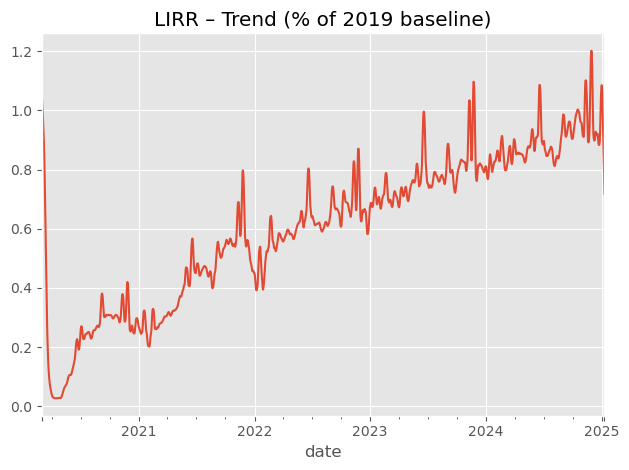

In [6]:
# %% ------------------------------------------------------------------
# SECTION 6 – LIRR TREND ANALYSIS  (answers Q6)
# ---------------------------------------------------------------------
col_lirr = find_pct_col("lirr")
lirr = df[["date", col_lirr]].dropna().set_index("date")
trend = STL(lirr[col_lirr], period=7).fit().trend
trend.plot(title="LIRR – Trend (% of 2019 baseline)")
plt.tight_layout();
plt.show()

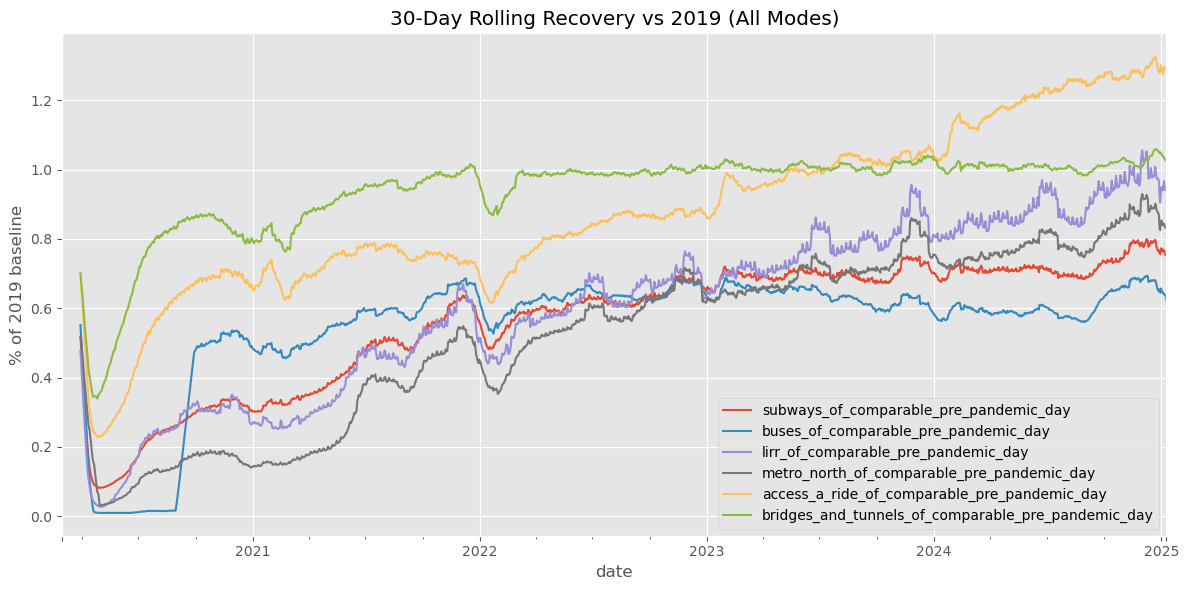

In [7]:
# %% ------------------------------------------------------------------
# SECTION 7 – RECOVERY CURVES FOR ALL MODES  (answers Q7)
# ---------------------------------------------------------------------
modes = ["subways", "buses", "lirr", "metro_north",
         "access_a_ride", "bridges_and_tunnels"]

recovery_cols = [find_pct_col(m) for m in modes]
recovery = df[["date"] + recovery_cols].set_index("date").rolling(30).mean()
recovery.plot(figsize=(12, 6),
              title="30-Day Rolling Recovery vs 2019 (All Modes)")
plt.ylabel("% of 2019 baseline")
plt.tight_layout();
plt.show()